In [60]:
#Extra stuff imported, I will keep it like this for testing 
import os
import re
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [61]:
#Folder Structure
DATA_DIR = pathlib.Path.cwd() / 'images' / 'Person'

items = (DATA_DIR / 'train').glob('**/*')

print("Body_Movements_Train")
for item in items:
    if item.is_dir():
        png_count = len(list(item.glob('*.png')))
        print(f"├── {item.name} [{png_count} .png files]")

#The "nothing" class is removed, because it was very small class around 90 images 
#and mostly containing no real features that can be learned by the model, mostly pure noise 

Body_Movements_Train
├── Ana [98 .png files]
├── Enrique [103 .png files]
├── Fran [59 .png files]
├── Mero [101 .png files]
├── Nobody [101 .png files]
├── Pana [69 .png files]
├── Sam [65 .png files]


In [62]:
# Define the base path to your images
# this path should have folders containing training images

train_path = DATA_DIR / 'train'
test_path = DATA_DIR / 'test'

# Remove hidden files (e.g., .DS_Store, ., ..)
def remove_hidden_files(path):
    for root, _, files in os.walk(path):
        for file in files:
            if file.startswith('.'):  # Exclude hidden files
                file_path = os.path.join(root, file)
                print(f"Removing hidden file: {file_path}")
                os.remove(file_path)

remove_hidden_files(train_path)
remove_hidden_files(test_path)

# # Shuffle the files in the training dataset directory
# def shuffle_training_files(base_path):
#     for class_folder in os.listdir(base_path):
#         class_path = os.path.join(base_path, class_folder)
#         if os.path.isdir(class_path):
#             files = os.listdir(class_path)
#             random.shuffle(files)  # Randomize file order
#             for i, file in enumerate(files):
#                 old_path = os.path.join(class_path, file)
#                 new_path = os.path.join(class_path, f"{i:06d}_{file}")  # Rename files to maintain order
#                 os.rename(old_path, new_path)

# shuffle_training_files(base_path)

When it comes to image sizes, the previous team use the flipped height and width. That is pretty bad for the model, it was able to learn features from a perspective that was different than the actual spectograms. 
Moreover the model was trained on both channels images, and the folder structure only had 2 categories in total. 

Now we set clear folder structure and proper image shape for the input. 

I recreated the script to generate the splits
!Checkout the Split_Script is easier to use now with clear indications. 

 (it will work properly now, after the updates some syntax feature deprecated and because of lack of comments and indications in the previous code, I was not able to use their confusion matrix code, but we have new code for that no worries.)

In [82]:
# Parameters
IMG_SIZE = (1000,512)       # time, n_subcarriers
BATCH_SIZE = 16
RANDOM_STATE = 42

# Data Preprocessing using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Load train and validation sets (90% for training, 10% for validation)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training",
    shuffle=True,
    seed=RANDOM_STATE
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=True,
    seed=RANDOM_STATE
)

test_generator = train_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

#Visualize this 
print("Train samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)
print("Test samples:", test_generator.samples)


# #There is an automatic data split with the .py script "Split_Script", this data should be the one that is used for training 
# #The rest is for validation and training

# for class_folder in os.listdir(base_path):
#     folder = os.path.join(base_path, class_folder)
#     if os.path.isdir(folder):
#         print(f"{class_folder}: {len(os.listdir(folder))} images")


Found 540 images belonging to 7 classes.
Found 56 images belonging to 7 classes.
Found 118 images belonging to 7 classes.
Train samples: 540
Validation samples: 56
Test samples: 118


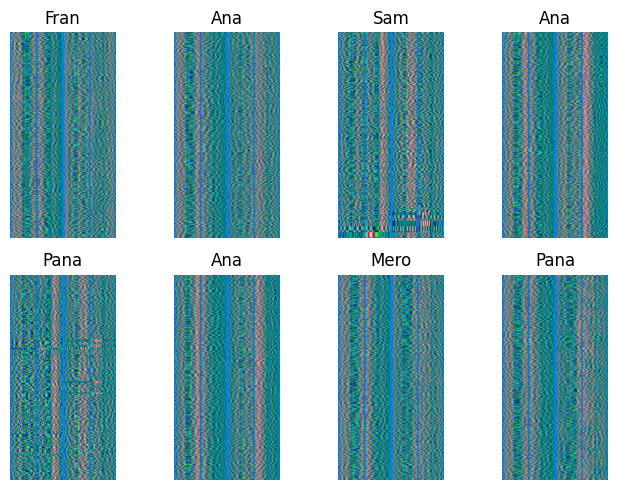

In [83]:
# Visualize some images 

# Get a batch of images and labels
images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

# Plot settings
cols = 4
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))

for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.grid(False)
    ax.axis('off')
    ax.imshow(images[i])
    true_label = class_names[np.argmax(labels[i])]
    ax.set_title(f"{true_label}")

plt.tight_layout()
plt.show()

In [84]:
# Build the CNN model

def make_model(n):

    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

        Conv2D(32, (5, 64*n)),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2*n,2*n)),
        Dropout(0.25),

        Conv2D(32, (15, 64)),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(5,5)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        
        Dense(len(train_generator.class_indices), activation='softmax')
    ])

    return model

The architecture will be revised. This simple one helps when it comes to testing 

In [81]:
# Compile the model
model = make_model(2)


model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


print(f"Number of training images: {train_generator.samples}")
print(f"Number of validation images: {validation_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")
model.summary()

Number of training images: 540
Number of validation images: 56
Class indices: {'Ana': 0, 'Enrique': 1, 'Fran': 2, 'Mero': 3, 'Nobody': 4, 'Pana': 5, 'Sam': 6}
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 996, 385, 32)      61472     
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 996, 385, 32)      0         
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 249, 96, 32)      0         
 g2D)                                                            
                                                                 
 dropout_57 (Dropout)        (None, 249, 96, 32)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 235, 33, 32)       983072    
                          

In [ ]:
# Train the model

model = make_model(2)
model.compile(optimizer=Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])


history = model.fit(
   train_generator,
   epochs=40,
   validation_data=validation_generator
)

model_name = 'tuto_person_model'

model.save(f'weights/{model_name}.keras')
print(f"Model saved as '{model_name}.keras'.")

score = model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
34/34 [==============================] - 106s 3s/step - loss: 1.9607 - accuracy: 0.1648 - val_loss: 1.9244 - val_accuracy: 0.1786
Epoch 2/20
34/34 [==============================] - 77s 2s/step - loss: 1.9411 - accuracy: 0.1981 - val_loss: 1.9021 - val_accuracy: 0.2143
Epoch 3/20
34/34 [==============================] - 77s 2s/step - loss: 1.9367 - accuracy: 0.1759 - val_loss: 1.8916 - val_accuracy: 0.1964
Epoch 4/20
34/34 [==============================] - 77s 2s/step - loss: 1.8829 - accuracy: 0.2167 - val_loss: 1.7947 - val_accuracy: 0.3750
Epoch 5/20
34/34 [==============================] - 76s 2s/step - loss: 1.7858 - accuracy: 0.2833 - val_loss: 1.6729 - val_accuracy: 0.3571
Epoch 6/20
34/34 [==============================] - 76s 2s/step - loss: 1.7160 - accuracy: 0.2963 - val_loss: 1.6877 - val_accuracy: 0.3750
Epoch 7/20
34/34 [==============================] - 76s 2s/step - loss: 1.6860 - accuracy: 0.2981 - val_loss: 1.6097 - val_accuracy: 0.3929
Epoch 8/20
34/34 [=

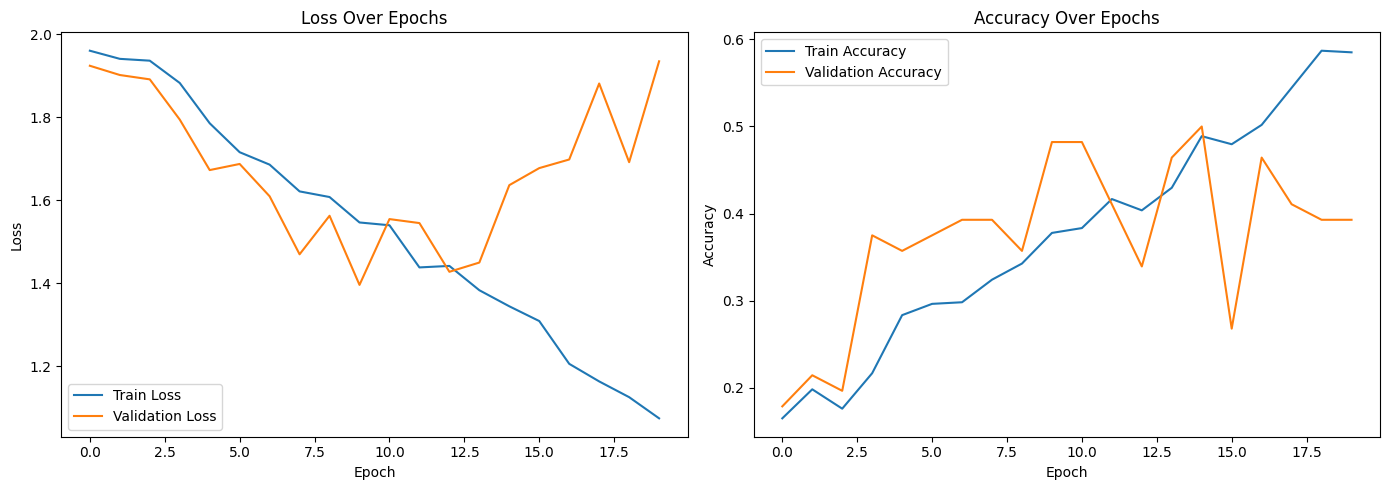

In [86]:
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Seems like the model is highly accurate and in not overfitting, however when we will have a look a the confusion matrix perspective will change....

118/118 [==============================] - 5s 33ms/step


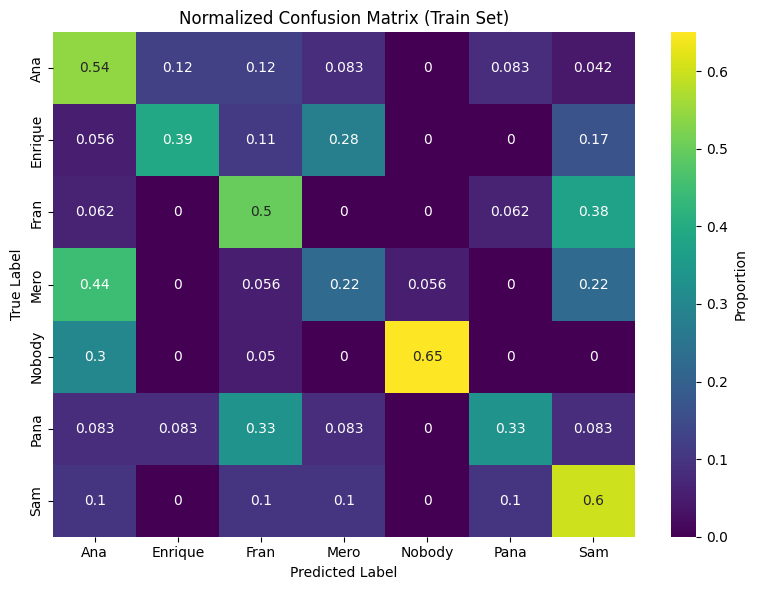

In [87]:
# model = make_model()
# model.load_weights('person_model.keras')


# Get true labels and predicted labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Predict probabilities
# the automatic shuffling needs to be disabled
# so that the indices in y_true and y_pred refer to the same images  
# test_generator.shuffle = False
# test_generator.index_array = None

y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percent = np.nan_to_num(cm_percent)  # Handle NaN if any class has 0 samples

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap="viridis", xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Proportion'})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Train Set)")
plt.tight_layout()
plt.show()

Yes it is very uniform. This is equivalent to random guessing. The model is pretty shallow (not enough layers). I purpose to use transfer learning, features of the spectograms are hard to read both for humans and the CNN. 

We can test the model with a normal well-known model like CIFAR or MINST to see weather it will be able to learn anything. 

Note that to this file we definately need to add one-hot encoded lables - the CNNs do not undestand words.